In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./data/augmented_data.csv")

In [3]:
data.nunique()

period                     5
minute                   139
second                    60
possession               290
duration               77925
competition_id            17
season_id                 41
match_id                3312
timestamp              82726
team                     288
player                  5638
freeze_frame           82866
play_pattern               9
position                  25
player_type                5
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length   

In [4]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "shot_angle", "duration", "competition_id", "season_id", "match_id", "player", "freeze_frame", "timestamp", "team", "xg_so_far", "location_x", "location_y", "game_state", "body_part", "defenders_3m_radius", "under_pressure", "goal_distance", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.059283
shooting_range         0.051634
best_distance          0.050111
defenders_triangle     0.042361
open_range             0.039239
location_x_distance    0.035795
goalkeeper_x           0.027903
location_y_distance    0.022428
goalkeeper_y           0.021242
is_penalty             0.015383
open_goal              0.012211
pass_length            0.011227
own_past_minute        0.010352
pass_duration          0.009865
good_foot              0.007790
period                 0.007609
num_passes             0.007302
first_time             0.006022
was_leading            0.005796
player_type            0.005495
own_past_15            0.005032
one_on_one             0.004748
past_minute            0.004649
pass_angle             0.004353
minute                 0.003255
past_15                0.001403
is_extra_time          0.001390
shots_so_far           0.000943
second                 0.000649
possession             0.000000
is_header              0.000000
aerial_w

In [5]:
# drop redundant features
data.drop(["location_x", "location_y", "game_state", "body_part", "defenders_3m_radius", "under_pressure", "player_type", "goal_distance"], axis=1, inplace=True)
# drop features that leak target information
data.drop(["end_location_x", "end_location_y", "shot_angle", "duration", "competition_id", "season_id", "match_id", "timestamp", "team", "player", "freeze_frame", "xg_so_far"], axis=1, inplace=True)
# drop low information features
data.drop(["period", "minute", "second", "possession", "aerial_won", "follows_dribble", "num_passes", "pass_length", "pass_duration", "pass_height", "pass_type", "pass_angle", "shots_so_far", "past_minute", "past_15", "own_past_minute", "own_past_15"], axis=1, inplace=True)
# drop penalties
data = data[data["is_penalty"] == False]

In [6]:
data.nunique()

play_pattern               9
position                  25
location_x_distance      635
location_y_distance      471
technique                  7
type                       4
is_penalty                 1
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
defenders_triangle        12
goalkeeper_x             258
goalkeeper_y             355
distance_to_goalie     45441
shooting_range         43788
open_range                12
best_distance          30176
statsbomb_xg           82416
is_goal                    2
good_foot                  2
was_leading                3
is_extra_time              2
dtype: int64

In [7]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "type", "position"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [8]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [9]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal"], axis=1)

In [10]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [11]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.2).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [12]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [13]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [14]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    return y_pred

In [15]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test)

In [16]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="gini", max_depth=12, max_leaf_nodes=100, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model

In [17]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.09, max_depth=8, min_samples_split=100, n_estimators=250, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)

    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [18]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.03869075259263101
Root Mean Squared Error: 0.06166697085091225
R-squared (R2 Score): 0.7516579594669008


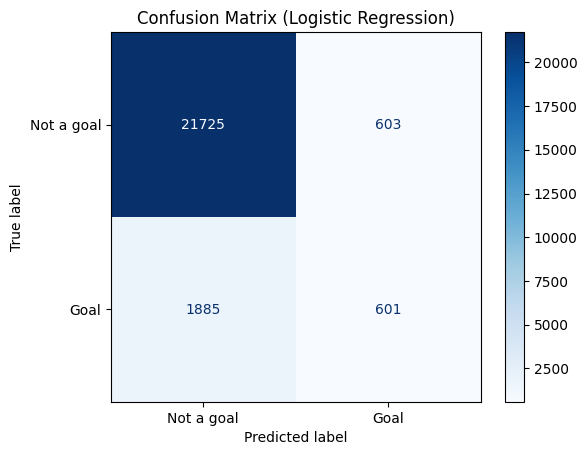


Logistic Regression
Accuracy: 0.8997340211171113
Precision: 0.49916943521594687
Recall: 0.2417538213998391
F1: 0.32574525745257454


In [19]:
X_train, X_test, y_train, y_test = preprocess_classifier(X, y2)
lor_xg = logistic_regression()

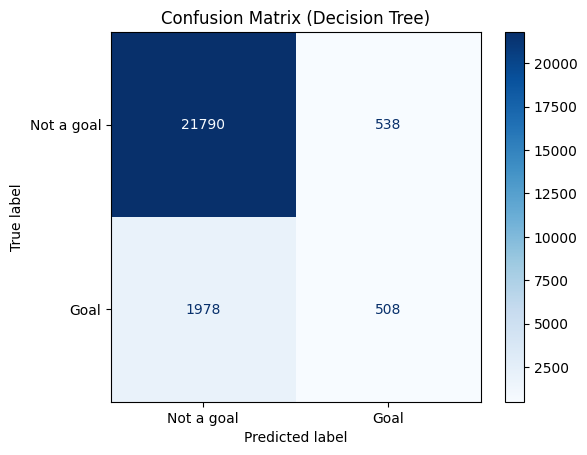


Decision Tree
Accuracy: 0.8986056258563714
Precision: 0.48565965583174
Recall: 0.20434432823813356
F1: 0.2876557191392978


In [20]:
dt_xg, viz = decision_tree()

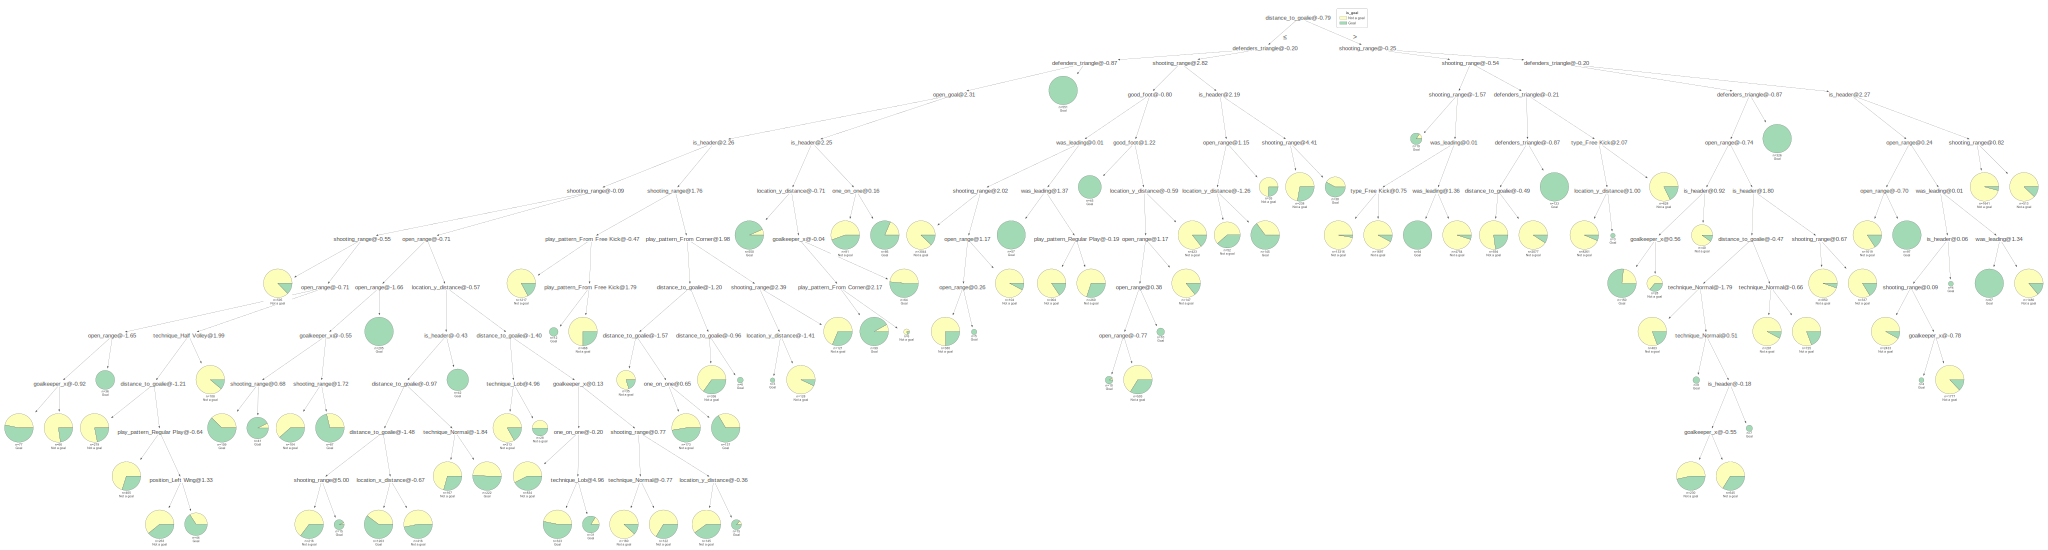

In [21]:
viz.view(fancy=False)

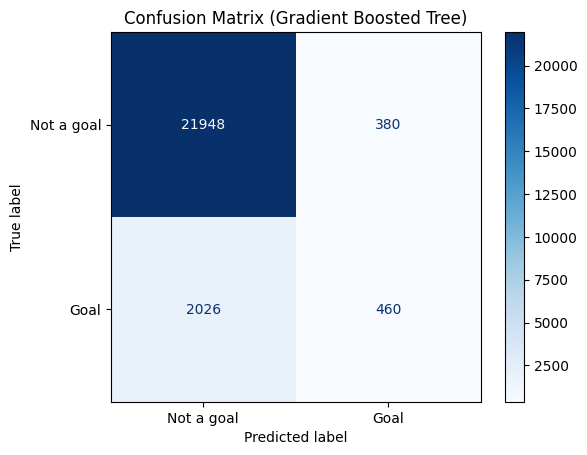


Gradient Boosted Tree
Accuracy: 0.9030386072378496
Precision: 0.5476190476190477
Recall: 0.1850362027353178
F1: 0.2766085387853277


In [22]:
gbt_xg = gradient_boosted_tree()

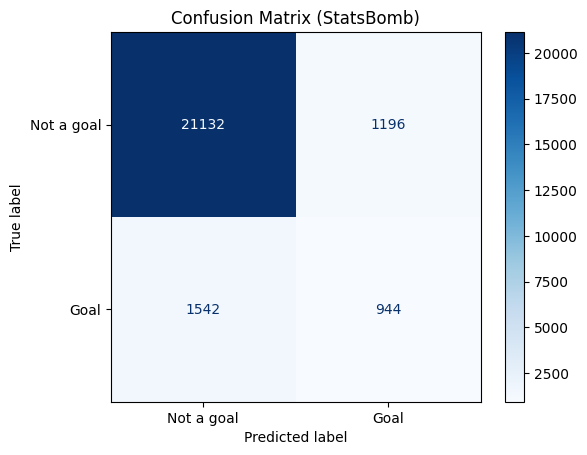


StatsBomb
Accuracy: 0.8896590634319336
Precision: 0.4411214953271028
Recall: 0.3797264682220434
F1: 0.40812797233030695


In [23]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
_, X_temp, _, sb_xg = preprocess_continuous(X, y1)
sb_pred = sb_xg.apply(lambda x: math.ceil(x-0.25))
calculate_stats(y_test, sb_pred, "StatsBomb")

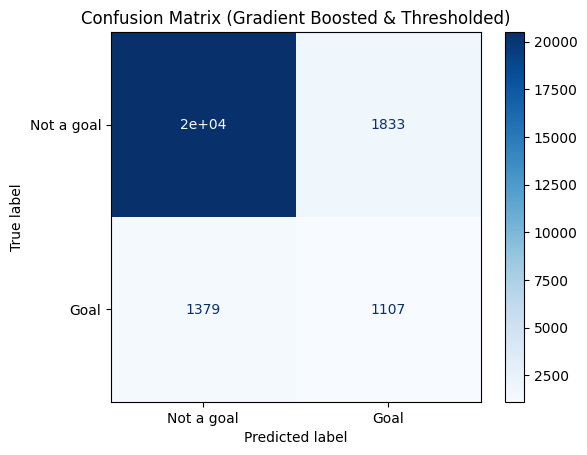


Gradient Boosted & Thresholded
Accuracy: 0.8705569436608366
Precision: 0.376530612244898
Recall: 0.4452936444086887
F1: 0.40803538518245486


In [24]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
gbt_pred = [math.ceil(x[1]-0.25) for x in gbt_xg]
calculate_stats(y_test, gbt_pred, "Gradient Boosted & Thresholded")

In [39]:
X.head()

,location_x_distance,location_y_distance,is_penalty,is_header,first_time,open_goal,one_on_one,defenders_triangle,goalkeeper_x,goalkeeper_y,...,position_Right Attacking Midfield,position_Right Back,position_Right Center Back,position_Right Center Forward,position_Right Center Midfield,position_Right Defensive Midfield,position_Right Midfield,position_Right Wing,position_Right Wing Back,position_Secondary Striker
0,5.0,15.0,False,False,False,False,False,1,120.0,26.0,...,0,0,0,1,0,0,0,0,0,0
1,11.0,11.0,False,False,False,False,False,4,119.0,40.0,...,0,0,0,1,0,0,0,0,0,0
2,21.0,12.0,False,False,True,False,False,5,119.0,40.0,...,0,0,0,0,0,0,0,0,0,0
3,13.0,0.0,False,False,False,False,False,3,119.0,38.0,...,0,0,0,0,0,0,0,0,0,0
4,12.0,8.0,False,False,True,False,False,3,119.0,38.0,...,0,0,1,0,0,0,0,0,0,0


In [41]:
X_train[:5]

array([[-1.31216227e+00,  4.04741676e-02,  0.00000000e+00,
        -4.37415309e-01, -6.66077339e-01, -1.05764326e-01,
        -2.35264282e-01, -2.03989721e-01,  1.74363845e-01,
         1.24803392e+00, -1.12957850e+00,  8.26444682e-02,
         2.53528079e-01, -1.27668142e+00, -8.12713660e-01,
         1.36818763e+00, -2.36805647e-01, -4.39531809e-01,
        -2.19319788e-01,  1.94372328e+00, -1.99172465e-01,
        -1.25572043e-01, -1.08477833e-01, -4.66652434e-01,
        -4.36089374e-02, -7.12750242e-01, -6.31940969e-02,
        -6.22225131e-02, -3.95602930e-01, -9.98185100e-02,
         5.37070538e-01, -7.31303533e-02, -2.64807061e-01,
        -1.70365539e-02, -2.28607320e-01, -3.47708845e-03,
         2.29338354e-01, -2.68500261e-01, -6.62089233e-02,
        -1.55058966e-01, -4.34135319e-01, -2.78273074e-02,
        -9.83510748e-03, -6.35786384e-02, -1.90889548e-01,
        -1.88254545e-01, -2.54864604e-01, -2.46805042e-01,
        -1.99401997e-01, -2.11670942e-01, -3.33281837e-0

In [25]:
df = pd.DataFrame({"lr_xg": lr_xg, "lor_xg": [x[1] for x in lor_xg], "dt_xg": [x[1] for x in dt_xg], "gbt_xg": [x[1] for x in gbt_xg], "sxg": sb_xg})
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lr_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lor_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["dt_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["gbt_xg"]), np.asarray(df["sxg"]))))

          0         1
0  1.000000  0.867031
1  0.867031  1.000000
          0         1
0  1.000000  0.888967
1  0.888967  1.000000
          0         1
0  1.000000  0.846975
1  0.846975  1.000000
          0         1
0  1.000000  0.859733
1  0.859733  1.000000


In [26]:
diff = gbt_pred - y_test
data_copy.iloc[diff[diff == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,second,possession,duration,competition_id,season_id,match_id,timestamp,team,...,good_foot,shots_so_far,xg_so_far,game_state,was_leading,past_minute,past_15,own_past_minute,own_past_15,is_extra_time
41198,2.0,81.0,4.0,151.0,2.456509,Indian Super league,2021/2022,3817886.0,00:36:04.314,Kerala Blasters,...,True,13,0.877704,1.0,1,1.0,2.0,1.0,2.0,False
7482,1.0,34.0,57.0,93.0,3.394190,FA Women's Super League,2018/2019,19810.0,00:34:57.530,Bristol City WFC,...,False,2,0.111244,-1.0,-1,2.0,4.0,1.0,4.0,False
77163,1.0,47.0,11.0,107.0,1.816030,Ligue 1,2015/2016,3900538.0,00:47:11.667,Guingamp,...,False,4,0.204867,-1.0,-1,1.0,1.0,1.0,1.0,False
75940,1.0,49.0,18.0,90.0,2.868910,Women's World Cup,2023,3893829.0,00:49:18.772,France Women's,...,True,18,2.147718,2.0,1,1.0,5.0,1.0,2.0,False
62636,2.0,63.0,1.0,165.0,1.796333,Serie A,2015/2016,3879742.0,00:18:01.574,AC Milan,...,True,9,0.485998,1.0,1,1.0,6.0,1.0,7.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,2.0,58.0,27.0,129.0,1.759000,NWSL,2018,7477.0,00:13:27.889,Portland Thorns,...,False,8,0.785182,3.0,1,1.0,4.0,1.0,1.0,False
1758,1.0,39.0,14.0,56.0,0.573000,FIFA World Cup,2018,7554.0,00:39:14.310,England,...,False,4,1.408958,3.0,1,2.0,3.0,1.0,1.0,False
42021,1.0,44.0,43.0,86.0,0.456438,La Liga,2015/2016,3825576.0,00:44:43.437,Valencia,...,True,1,0.038833,-1.0,-1,1.0,3.0,1.0,2.0,False
8780,2.0,65.0,0.0,144.0,0.139073,La Liga,2005/2006,68321.0,00:20:00.742,Barcelona,...,False,14,1.156385,-1.0,-1,2.0,9.0,1.0,2.0,False


In [27]:
diff_sb = sb_pred - y_test
data_copy.iloc[diff_sb[diff_sb == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,second,possession,duration,competition_id,season_id,match_id,timestamp,team,...,good_foot,shots_so_far,xg_so_far,game_state,was_leading,past_minute,past_15,own_past_minute,own_past_15,is_extra_time
75341,1.0,3.0,35.0,10.0,2.117102,Women's World Cup,2023,3893807.0,00:03:35.731,Republic of Ireland Women's,...,True,2,0.449885,0.0,0,3.0,4.0,1.0,2.0,False
41198,2.0,81.0,4.0,151.0,2.456509,Indian Super league,2021/2022,3817886.0,00:36:04.314,Kerala Blasters,...,True,13,0.877704,1.0,1,1.0,2.0,1.0,2.0,False
7482,1.0,34.0,57.0,93.0,3.394190,FA Women's Super League,2018/2019,19810.0,00:34:57.530,Bristol City WFC,...,False,2,0.111244,-1.0,-1,2.0,4.0,1.0,4.0,False
77163,1.0,47.0,11.0,107.0,1.816030,Ligue 1,2015/2016,3900538.0,00:47:11.667,Guingamp,...,False,4,0.204867,-1.0,-1,1.0,1.0,1.0,1.0,False
75940,1.0,49.0,18.0,90.0,2.868910,Women's World Cup,2023,3893829.0,00:49:18.772,France Women's,...,True,18,2.147718,2.0,1,1.0,5.0,1.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68052,2.0,57.0,42.0,134.0,1.159092,1. Bundesliga,2015/2016,3890301.0,00:12:42.473,Borussia Dortmund,...,False,11,1.306002,1.0,1,1.0,4.0,1.0,2.0,False
67019,2.0,72.0,14.0,138.0,0.461844,1. Bundesliga,2015/2016,3890259.0,00:27:14.850,Bayern Munich,...,False,17,1.879459,3.0,1,2.0,8.0,1.0,1.0,False
6419,1.0,12.0,30.0,29.0,0.893162,FA Women's Super League,2018/2019,19767.0,00:12:30.099,Everton LFC,...,False,0,0.000000,0.0,0,1.0,6.0,1.0,3.0,False
56935,2.0,87.0,24.0,177.0,0.720786,Serie A,2015/2016,3878598.0,00:42:24.506,Palermo,...,False,11,0.890094,0.0,0,1.0,5.0,2.0,3.0,False


In [28]:
_, data_copy_test, _, gbt_xg_test = train_test_split(data_copy[data_copy["is_penalty"] == False], y2, test_size=0.3, random_state=20)
diff_xg = [x[1] for x in gbt_xg] - sb_xg
data_copy_test["diff"] = diff_xg
data_copy_test["gbt_xg"] = [x[1] for x in gbt_xg]
data_copy_test["sb_xg"] = sb_xg
data_copy_test.sort_values(by=["diff"])

,period,minute,second,possession,duration,competition_id,season_id,match_id,timestamp,team,...,game_state,was_leading,past_minute,past_15,own_past_minute,own_past_15,is_extra_time,diff,gbt_xg,sb_xg
8780,2.0,65.0,0.0,144.0,0.139073,La Liga,2005/2006,68321.0,00:20:00.742,Barcelona,...,-1.0,-1,2.0,9.0,1.0,2.0,False,-0.713516,0.150945,0.864461
83566,1.0,36.0,45.0,57.0,0.174877,African Cup of Nations,2023,3922240.0,00:36:45.900,Congo DR,...,0.0,0,3.0,8.0,1.0,8.0,False,-0.693884,0.180375,0.874259
69099,2.0,87.0,28.0,203.0,0.270089,1. Bundesliga,2015/2016,3890340.0,00:42:28.660,Hamburger SV,...,0.0,0,1.0,6.0,1.0,1.0,False,-0.592172,0.324440,0.916613
19049,1.0,1.0,5.0,5.0,0.423330,La Liga,2019/2020,303666.0,00:01:05.479,Granada,...,0.0,0,1.0,1.0,1.0,1.0,False,-0.522356,0.256145,0.778502
22146,1.0,4.0,52.0,10.0,0.172284,Premier League,2003/2004,3749448.0,00:04:52.229,Liverpool,...,0.0,0,1.0,2.0,2.0,2.0,False,-0.415448,0.375627,0.791075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79373,2.0,68.0,16.0,156.0,1.134123,Ligue 1,2015/2016,3900637.0,00:23:16.970,OGC Nice,...,0.0,0,1.0,3.0,1.0,1.0,False,0.828784,0.841144,0.012360
75341,1.0,3.0,35.0,10.0,2.117102,Women's World Cup,2023,3893807.0,00:03:35.731,Republic of Ireland Women's,...,0.0,0,3.0,4.0,1.0,2.0,False,0.832281,0.832461,0.000180
62072,1.0,5.0,18.0,20.0,1.407091,Serie A,2015/2016,3879721.0,00:05:18.856,AC Milan,...,0.0,0,1.0,3.0,1.0,3.0,False,0.910864,0.911044,0.000180
71704,1.0,17.0,23.0,38.0,1.609954,1. Bundesliga,2015/2016,3890441.0,00:17:23.873,VfB Stuttgart,...,0.0,0,2.0,3.0,2.0,2.0,False,0.914850,0.915030,0.000180


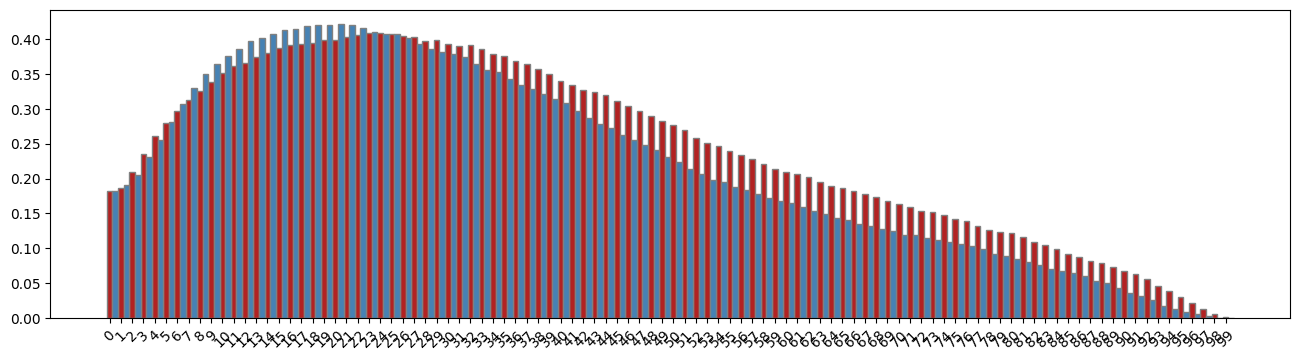

In [29]:
my_f1_scores = []
sb_f1_scores = []
for threshold in range(0, 100):
    gbt_pred = [math.ceil(x[1]-(threshold/100)) for x in gbt_xg]
    sb_pred = [math.ceil(x-(threshold/100)) for x in sb_xg]
    my_f1 = f1_score(y_test, gbt_pred)
    sb_f1 = f1_score(y_test, sb_pred)
    my_f1_scores.append(my_f1)
    sb_f1_scores.append(sb_f1)

barWidth = 0.5
r1 = np.arange(len(my_f1_scores))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(16,4))
plt.bar(r1, pd.Series(my_f1_scores), color="firebrick", width=barWidth, edgecolor='grey', label='Our Prediction')
plt.bar(r2, pd.Series(sb_f1_scores), color="steelblue", width=barWidth, edgecolor='grey', label='SB Prediction')

plt.xticks(r1, [x for x in range(0, 100)], rotation=45)
plt.show()

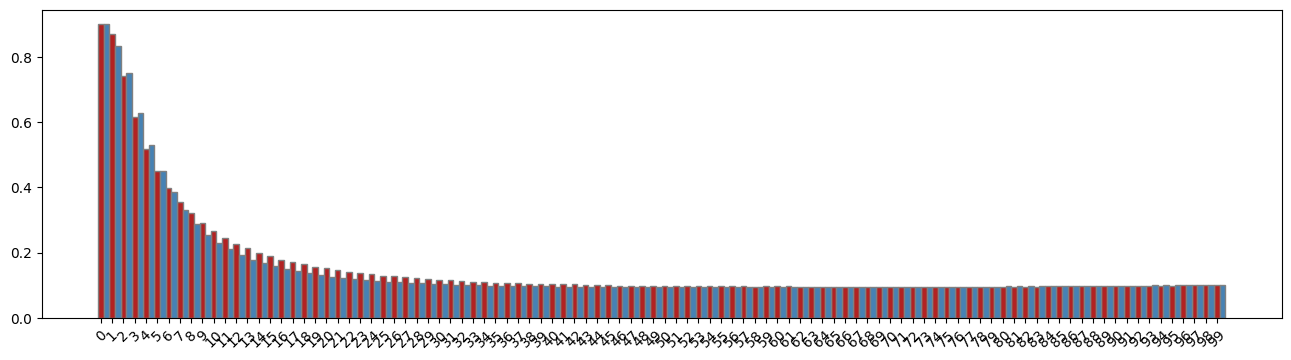

0.10014507939066655


In [30]:
my_brier_scores = []
sb_brier_scores = []
for threshold in range(0, 100):
    gbt_pred = [math.ceil(x[1]-(threshold/100)) for x in gbt_xg]
    sb_pred = [math.ceil(x-(threshold/100)) for x in sb_xg]
    my_brier = brier_score_loss(y_test, gbt_pred)
    sb_brier = brier_score_loss(y_test, sb_pred)
    my_brier_scores.append(my_brier)
    sb_brier_scores.append(sb_brier)

barWidth = 0.5
r1 = np.arange(len(my_brier_scores))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(16,4))
plt.bar(r1, pd.Series(my_brier_scores), color="firebrick", width=barWidth, edgecolor='grey', label='Our Prediction')
plt.bar(r2, pd.Series(sb_brier_scores), color="steelblue", width=barWidth, edgecolor='grey', label='SB Prediction')

plt.xticks(r1, [x for x in range(0, 100)], rotation=45)
plt.show()
print(my_brier_scores[-1])

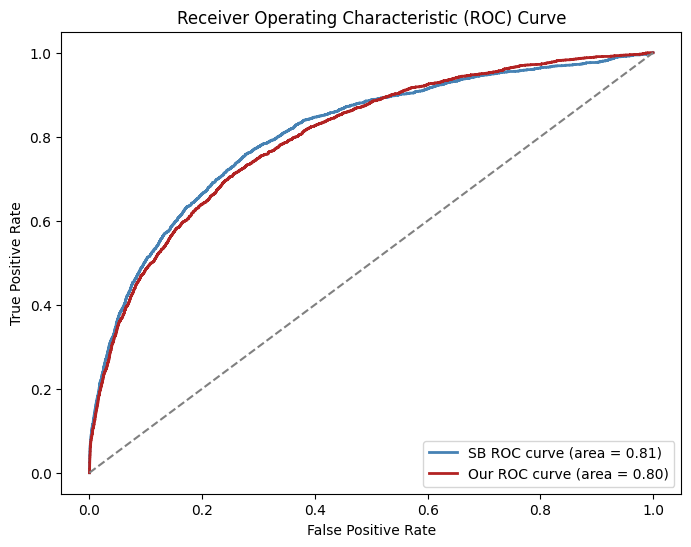

In [31]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, [x[1] for x in gbt_xg])
roc_auc1 = roc_auc_score(y_test, [x[1] for x in gbt_xg])
fpr2, tpr2, thresholds2 = roc_curve(y_test, sb_xg)
roc_auc2 = roc_auc_score(y_test, sb_xg)

plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='steelblue', lw=2, label='SB ROC curve (area = {:.2f})'.format(roc_auc2))
plt.plot(fpr1, tpr1, color='firebrick', lw=2, label='Our ROC curve (area = {:.2f})'.format(roc_auc1))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot the random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

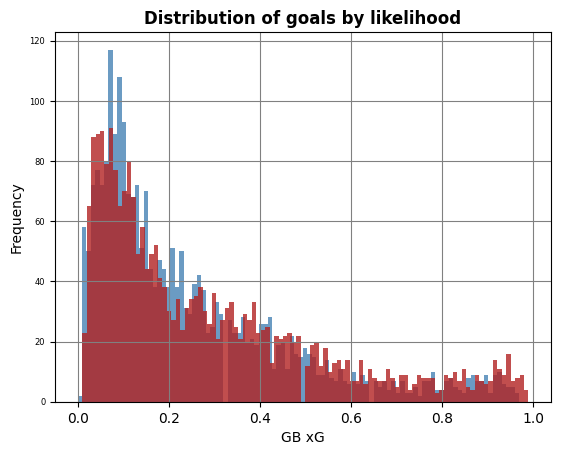

In [32]:
ax = data_copy_test[(data_copy_test["is_goal"] == True)]["sb_xg"].apply(lambda x: round(x, 2)).hist(bins=100, xlabelsize=10, ylabelsize=6, alpha=0.8, color="steelblue")
ax2 = data_copy_test[(data_copy_test["is_goal"] == True)]["gbt_xg"].apply(lambda x: round(x, 2)).hist(bins=100, xlabelsize=10, ylabelsize=6, alpha=0.8, color="firebrick")
ax.set_title('Distribution of goals by likelihood', weight='bold')
ax.set_xlabel('GB xG')
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=12, max_leaf_nodes=100, min_samples_split=100)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [34]:
importance = dt.feature_importances
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00189
Feature: 1, Score: 0.01473
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.04441
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.05716
Feature: 6, Score: 0.00439
Feature: 7, Score: 0.27032
Feature: 8, Score: 0.01019
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.31605
Feature: 11, Score: 0.10852
Feature: 12, Score: 0.06975
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.01277
Feature: 15, Score: 0.06289
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00479
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00334
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00245
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00140
Feature: 29, Score: 0.00183
Feature: 30, Score: 0.00841
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00127
Feature: 35, Score: 0.00000
Fe

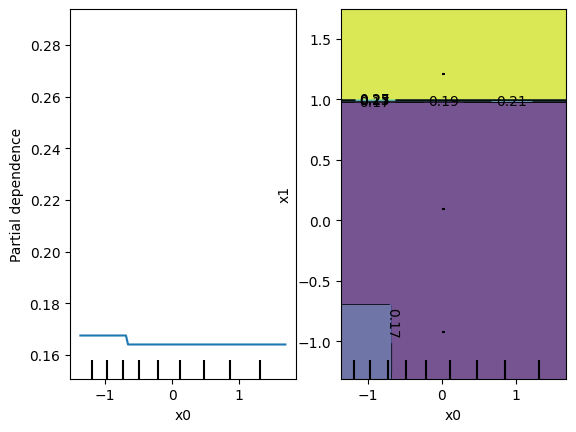

In [35]:
PartialDependenceDisplay.from_estimator(dt, X_train, [7, (0, 1)])

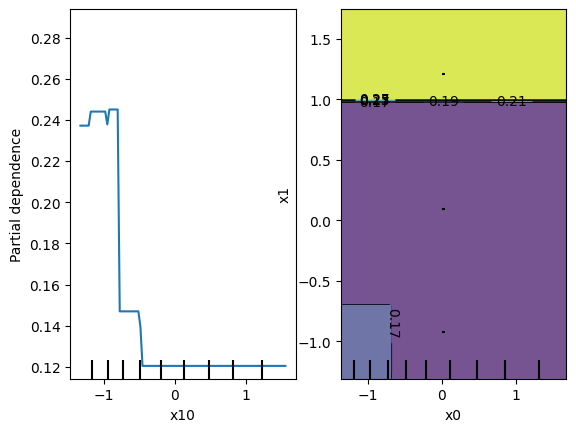

In [36]:
PartialDependenceDisplay.from_estimator(dt, X_train, [10, (0, 1)])